In [1]:
!git clone https://github.com/NVlabs/ffhq-dataset.git

Cloning into 'ffhq-dataset'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 51 (delta 0), reused 1 (delta 0), pack-reused 47
Unpacking objects: 100% (51/51), done.


In [2]:
!python ffhq-dataset/download_ffhq.py -t

| 100.00% done  2/2 files  0.25/0.25 GB   0.16 GB/s   ETA: done    
Parsing JSON metadata...
| 100.00% done  70001/70001 files  1.96/1.96 GB   2.14 MB/s   ETA: done    


In [0]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as Fa
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [4]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Hyperparameters

In [0]:
batch_size = 64
epochs = 30
log_interval = 10
x_dim = 128
y_dim = 128
nb_channels = 3
embedding_dim = 2048
base_dir = 'thumbnails128x128'

## Load data

In [0]:
def load_dataset(data_path):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([torchvision.transforms.ToTensor()])
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader

train_loader = load_dataset(f'{base_dir}')
test_loader = load_dataset(f'{base_dir}')

## Example image

In [0]:
def plot_img(img):
  plt.figure()
  plt.imshow(img.numpy())
  plt.show()

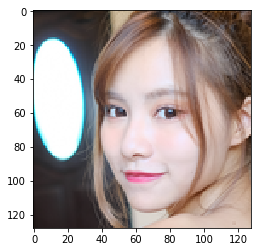

In [8]:
img = next(iter(train_loader))[0][0]
img = img.permute(1, 2, 0)
img = img.view(img.shape[0], img.shape[1], nb_channels)
plot_img(img)

## Models

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim*y_dim*nb_channels, embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, x_dim*y_dim*nb_channels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim*y_dim*nb_channels))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:

class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv31 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(128)
        self.conv32 = nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(32 * 32 * 16, embedding_dim)
        self.fc_bn1 = nn.BatchNorm1d(embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)

        # Sampling vector
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc_bn3 = nn.BatchNorm1d(embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, 32 * 32 * 16)
        self.fc_bn4 = nn.BatchNorm1d(32 * 32 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv31 = self.relu(self.bn31(self.conv31(conv3)))
        conv32 = self.relu(self.bn32(self.conv32(conv31)))
        conv4 = self.relu(self.bn4(self.conv4(conv32))).view(-1, 32 * 32 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 32, 32)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, x_dim, y_dim)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim*y_dim*nb_channels), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [0]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        self.bce_loss = nn.BCELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_rec = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_rec + loss_KLD

In [0]:
model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = CustomLoss()

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_func(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [0]:
import os
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, nb_channels, x_dim, y_dim)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

Train Epoch: 1 [0/70000 (0%)]	Loss: 35497.480469
Train Epoch: 1 [640/70000 (1%)]	Loss: 10061.113281
Train Epoch: 1 [1280/70000 (2%)]	Loss: 4754.276855
Train Epoch: 1 [1920/70000 (3%)]	Loss: 3568.981934
Train Epoch: 1 [2560/70000 (4%)]	Loss: 2883.658936
Train Epoch: 1 [3200/70000 (5%)]	Loss: 2976.242432
Train Epoch: 1 [3840/70000 (5%)]	Loss: 2480.364502
Train Epoch: 1 [4480/70000 (6%)]	Loss: 2396.041504
Train Epoch: 1 [5120/70000 (7%)]	Loss: 2233.341064
Train Epoch: 1 [5760/70000 (8%)]	Loss: 2166.316406
Train Epoch: 1 [6400/70000 (9%)]	Loss: 1990.416016
Train Epoch: 1 [7040/70000 (10%)]	Loss: 2082.499268
Train Epoch: 1 [7680/70000 (11%)]	Loss: 1959.510742
Train Epoch: 1 [8320/70000 (12%)]	Loss: 1842.350342
Train Epoch: 1 [8960/70000 (13%)]	Loss: 1905.549683
Train Epoch: 1 [9600/70000 (14%)]	Loss: 1982.232910
Train Epoch: 1 [10240/70000 (15%)]	Loss: 1844.110596
Train Epoch: 1 [10880/70000 (16%)]	Loss: 1740.443115
Train Epoch: 1 [11520/70000 (16%)]	Loss: 1873.348633
Train Epoch: 1 [12160/

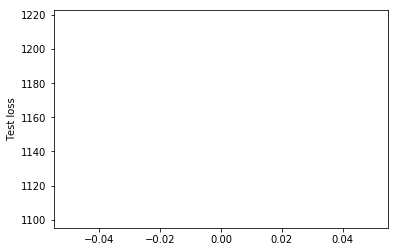

Train Epoch: 2 [0/70000 (0%)]	Loss: 1243.455200
Train Epoch: 2 [640/70000 (1%)]	Loss: 1307.171265
Train Epoch: 2 [1280/70000 (2%)]	Loss: 1258.779785
Train Epoch: 2 [1920/70000 (3%)]	Loss: 1305.511719
Train Epoch: 2 [2560/70000 (4%)]	Loss: 1273.118408
Train Epoch: 2 [3200/70000 (5%)]	Loss: 1681.795532
Train Epoch: 2 [3840/70000 (5%)]	Loss: 1294.100464
Train Epoch: 2 [4480/70000 (6%)]	Loss: 1319.432007
Train Epoch: 2 [5120/70000 (7%)]	Loss: 1271.805176
Train Epoch: 2 [5760/70000 (8%)]	Loss: 1214.257935
Train Epoch: 2 [6400/70000 (9%)]	Loss: 1203.581665
Train Epoch: 2 [7040/70000 (10%)]	Loss: 1256.495483
Train Epoch: 2 [7680/70000 (11%)]	Loss: 1287.153687
Train Epoch: 2 [8320/70000 (12%)]	Loss: 1310.409668
Train Epoch: 2 [8960/70000 (13%)]	Loss: 1251.212402
Train Epoch: 2 [9600/70000 (14%)]	Loss: 1342.052612
Train Epoch: 2 [10240/70000 (15%)]	Loss: 1240.889648
Train Epoch: 2 [10880/70000 (16%)]	Loss: 1244.179321
Train Epoch: 2 [11520/70000 (16%)]	Loss: 1254.491211
Train Epoch: 2 [12160/70

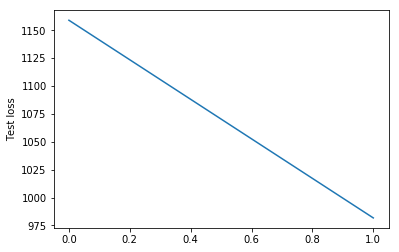

Train Epoch: 3 [0/70000 (0%)]	Loss: 1198.895020
Train Epoch: 3 [640/70000 (1%)]	Loss: 1145.092163
Train Epoch: 3 [1280/70000 (2%)]	Loss: 1098.785156
Train Epoch: 3 [1920/70000 (3%)]	Loss: 1122.393066
Train Epoch: 3 [2560/70000 (4%)]	Loss: 1206.649658
Train Epoch: 3 [3200/70000 (5%)]	Loss: 1198.165283
Train Epoch: 3 [3840/70000 (5%)]	Loss: 1128.701172
Train Epoch: 3 [4480/70000 (6%)]	Loss: 1103.783447
Train Epoch: 3 [5120/70000 (7%)]	Loss: 1141.627197
Train Epoch: 3 [5760/70000 (8%)]	Loss: 1087.555420
Train Epoch: 3 [6400/70000 (9%)]	Loss: 1075.470947
Train Epoch: 3 [7040/70000 (10%)]	Loss: 1122.319336
Train Epoch: 3 [7680/70000 (11%)]	Loss: 1114.846924
Train Epoch: 3 [8320/70000 (12%)]	Loss: 1088.995117
Train Epoch: 3 [8960/70000 (13%)]	Loss: 1061.933228
Train Epoch: 3 [9600/70000 (14%)]	Loss: 1022.721680
Train Epoch: 3 [10240/70000 (15%)]	Loss: 1219.696289
Train Epoch: 3 [10880/70000 (16%)]	Loss: 1153.407715
Train Epoch: 3 [11520/70000 (16%)]	Loss: 1186.742432
Train Epoch: 3 [12160/70

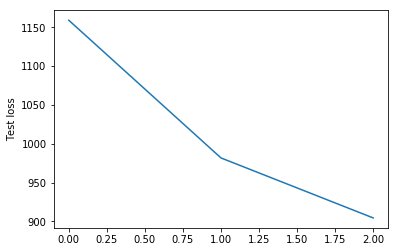

Train Epoch: 4 [0/70000 (0%)]	Loss: 1044.894531
Train Epoch: 4 [640/70000 (1%)]	Loss: 1024.108032
Train Epoch: 4 [1280/70000 (2%)]	Loss: 1038.666748
Train Epoch: 4 [1920/70000 (3%)]	Loss: 1046.970093
Train Epoch: 4 [2560/70000 (4%)]	Loss: 994.134033
Train Epoch: 4 [3200/70000 (5%)]	Loss: 1070.494629
Train Epoch: 4 [3840/70000 (5%)]	Loss: 985.250244
Train Epoch: 4 [4480/70000 (6%)]	Loss: 1115.821045
Train Epoch: 4 [5120/70000 (7%)]	Loss: 1028.424438
Train Epoch: 4 [5760/70000 (8%)]	Loss: 1073.563110
Train Epoch: 4 [6400/70000 (9%)]	Loss: 1034.854492
Train Epoch: 4 [7040/70000 (10%)]	Loss: 1037.818604
Train Epoch: 4 [7680/70000 (11%)]	Loss: 968.141357
Train Epoch: 4 [8320/70000 (12%)]	Loss: 1039.330811
Train Epoch: 4 [8960/70000 (13%)]	Loss: 1055.482666
Train Epoch: 4 [9600/70000 (14%)]	Loss: 1006.351562
Train Epoch: 4 [10240/70000 (15%)]	Loss: 971.811035
Train Epoch: 4 [10880/70000 (16%)]	Loss: 1000.217163
Train Epoch: 4 [11520/70000 (16%)]	Loss: 1019.052063
Train Epoch: 4 [12160/70000 

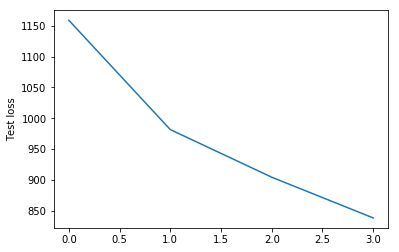

Train Epoch: 5 [0/70000 (0%)]	Loss: 977.277222
Train Epoch: 5 [640/70000 (1%)]	Loss: 989.348816
Train Epoch: 5 [1280/70000 (2%)]	Loss: 946.185059
Train Epoch: 5 [1920/70000 (3%)]	Loss: 981.661133
Train Epoch: 5 [2560/70000 (4%)]	Loss: 1037.063477
Train Epoch: 5 [3200/70000 (5%)]	Loss: 987.433350
Train Epoch: 5 [3840/70000 (5%)]	Loss: 1047.742065
Train Epoch: 5 [4480/70000 (6%)]	Loss: 964.045349
Train Epoch: 5 [5120/70000 (7%)]	Loss: 916.198730
Train Epoch: 5 [5760/70000 (8%)]	Loss: 988.225037
Train Epoch: 5 [6400/70000 (9%)]	Loss: 1048.539551
Train Epoch: 5 [7040/70000 (10%)]	Loss: 1006.273438
Train Epoch: 5 [7680/70000 (11%)]	Loss: 1063.491699
Train Epoch: 5 [8320/70000 (12%)]	Loss: 933.144409
Train Epoch: 5 [8960/70000 (13%)]	Loss: 954.448914
Train Epoch: 5 [9600/70000 (14%)]	Loss: 933.977905
Train Epoch: 5 [10240/70000 (15%)]	Loss: 972.085938
Train Epoch: 5 [10880/70000 (16%)]	Loss: 955.901855
Train Epoch: 5 [11520/70000 (16%)]	Loss: 963.929077
Train Epoch: 5 [12160/70000 (17%)]	Los

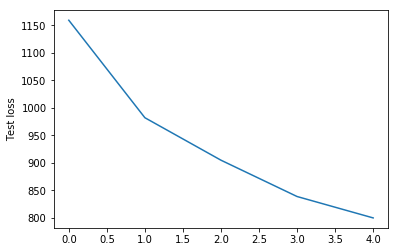

Train Epoch: 6 [0/70000 (0%)]	Loss: 1000.380981
Train Epoch: 6 [640/70000 (1%)]	Loss: 938.649048
Train Epoch: 6 [1280/70000 (2%)]	Loss: 904.512329
Train Epoch: 6 [1920/70000 (3%)]	Loss: 929.075317
Train Epoch: 6 [2560/70000 (4%)]	Loss: 947.021484
Train Epoch: 6 [3200/70000 (5%)]	Loss: 1002.629700
Train Epoch: 6 [3840/70000 (5%)]	Loss: 953.030090
Train Epoch: 6 [4480/70000 (6%)]	Loss: 887.626038
Train Epoch: 6 [5120/70000 (7%)]	Loss: 918.924744
Train Epoch: 6 [5760/70000 (8%)]	Loss: 902.390442
Train Epoch: 6 [6400/70000 (9%)]	Loss: 879.827881
Train Epoch: 6 [7040/70000 (10%)]	Loss: 948.093323
Train Epoch: 6 [7680/70000 (11%)]	Loss: 1079.784180
Train Epoch: 6 [8320/70000 (12%)]	Loss: 944.933472
Train Epoch: 6 [8960/70000 (13%)]	Loss: 928.109985
Train Epoch: 6 [9600/70000 (14%)]	Loss: 869.609863
Train Epoch: 6 [10240/70000 (15%)]	Loss: 979.692688
Train Epoch: 6 [10880/70000 (16%)]	Loss: 904.777527
Train Epoch: 6 [11520/70000 (16%)]	Loss: 997.835022
Train Epoch: 6 [12160/70000 (17%)]	Loss:

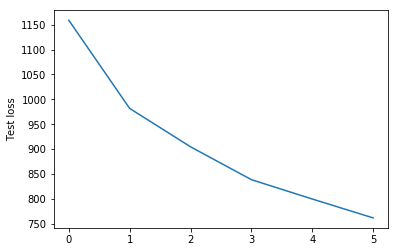

Train Epoch: 7 [0/70000 (0%)]	Loss: 883.461853
Train Epoch: 7 [640/70000 (1%)]	Loss: 896.753662
Train Epoch: 7 [1280/70000 (2%)]	Loss: 920.183411
Train Epoch: 7 [1920/70000 (3%)]	Loss: 899.649414
Train Epoch: 7 [2560/70000 (4%)]	Loss: 902.399780
Train Epoch: 7 [3200/70000 (5%)]	Loss: 886.786377
Train Epoch: 7 [3840/70000 (5%)]	Loss: 844.382141
Train Epoch: 7 [4480/70000 (6%)]	Loss: 928.463013
Train Epoch: 7 [5120/70000 (7%)]	Loss: 897.582031
Train Epoch: 7 [5760/70000 (8%)]	Loss: 888.359497
Train Epoch: 7 [6400/70000 (9%)]	Loss: 872.964844
Train Epoch: 7 [7040/70000 (10%)]	Loss: 935.290161
Train Epoch: 7 [7680/70000 (11%)]	Loss: 969.567078
Train Epoch: 7 [8320/70000 (12%)]	Loss: 955.345337
Train Epoch: 7 [8960/70000 (13%)]	Loss: 918.987305
Train Epoch: 7 [9600/70000 (14%)]	Loss: 901.953552
Train Epoch: 7 [10240/70000 (15%)]	Loss: 902.335327
Train Epoch: 7 [10880/70000 (16%)]	Loss: 921.066040
Train Epoch: 7 [11520/70000 (16%)]	Loss: 899.417236
Train Epoch: 7 [12160/70000 (17%)]	Loss: 89

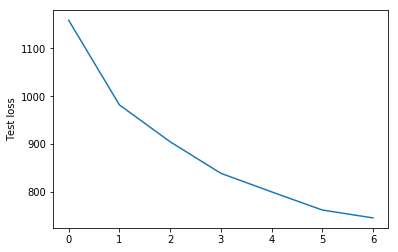

Train Epoch: 8 [0/70000 (0%)]	Loss: 927.269653
Train Epoch: 8 [640/70000 (1%)]	Loss: 917.842773
Train Epoch: 8 [1280/70000 (2%)]	Loss: 934.414062
Train Epoch: 8 [1920/70000 (3%)]	Loss: 858.089111
Train Epoch: 8 [2560/70000 (4%)]	Loss: 844.218933
Train Epoch: 8 [3200/70000 (5%)]	Loss: 817.497925
Train Epoch: 8 [3840/70000 (5%)]	Loss: 899.650757
Train Epoch: 8 [4480/70000 (6%)]	Loss: 886.053589
Train Epoch: 8 [5120/70000 (7%)]	Loss: 868.283081
Train Epoch: 8 [5760/70000 (8%)]	Loss: 879.843079
Train Epoch: 8 [6400/70000 (9%)]	Loss: 792.813965
Train Epoch: 8 [7040/70000 (10%)]	Loss: 807.979858
Train Epoch: 8 [7680/70000 (11%)]	Loss: 853.675598
Train Epoch: 8 [8320/70000 (12%)]	Loss: 846.293762
Train Epoch: 8 [8960/70000 (13%)]	Loss: 878.126343
Train Epoch: 8 [9600/70000 (14%)]	Loss: 847.177612
Train Epoch: 8 [10240/70000 (15%)]	Loss: 867.135132
Train Epoch: 8 [10880/70000 (16%)]	Loss: 856.310059
Train Epoch: 8 [11520/70000 (16%)]	Loss: 863.651855
Train Epoch: 8 [12160/70000 (17%)]	Loss: 82

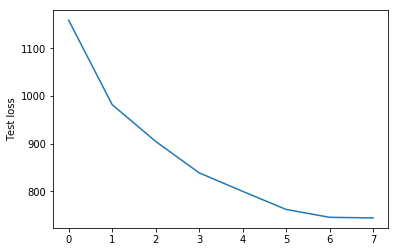

Train Epoch: 9 [0/70000 (0%)]	Loss: 817.180176
Train Epoch: 9 [640/70000 (1%)]	Loss: 818.131958
Train Epoch: 9 [1280/70000 (2%)]	Loss: 832.628357
Train Epoch: 9 [1920/70000 (3%)]	Loss: 848.590698
Train Epoch: 9 [2560/70000 (4%)]	Loss: 850.287476
Train Epoch: 9 [3200/70000 (5%)]	Loss: 823.709717
Train Epoch: 9 [3840/70000 (5%)]	Loss: 819.611328
Train Epoch: 9 [4480/70000 (6%)]	Loss: 798.142517
Train Epoch: 9 [5120/70000 (7%)]	Loss: 852.427979
Train Epoch: 9 [5760/70000 (8%)]	Loss: 829.270813
Train Epoch: 9 [6400/70000 (9%)]	Loss: 820.082886
Train Epoch: 9 [7040/70000 (10%)]	Loss: 806.425354
Train Epoch: 9 [7680/70000 (11%)]	Loss: 895.455627
Train Epoch: 9 [8320/70000 (12%)]	Loss: 810.841736
Train Epoch: 9 [8960/70000 (13%)]	Loss: 830.732910
Train Epoch: 9 [9600/70000 (14%)]	Loss: 882.689880
Train Epoch: 9 [10240/70000 (15%)]	Loss: 816.869263
Train Epoch: 9 [10880/70000 (16%)]	Loss: 848.214478
Train Epoch: 9 [11520/70000 (16%)]	Loss: 817.705322
Train Epoch: 9 [12160/70000 (17%)]	Loss: 82

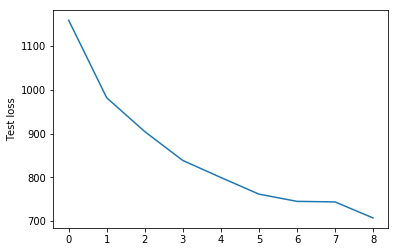

Train Epoch: 10 [0/70000 (0%)]	Loss: 838.907349
Train Epoch: 10 [640/70000 (1%)]	Loss: 841.262085
Train Epoch: 10 [1280/70000 (2%)]	Loss: 855.573059
Train Epoch: 10 [1920/70000 (3%)]	Loss: 806.262268
Train Epoch: 10 [2560/70000 (4%)]	Loss: 785.467773
Train Epoch: 10 [3200/70000 (5%)]	Loss: 821.704346
Train Epoch: 10 [3840/70000 (5%)]	Loss: 772.888184
Train Epoch: 10 [4480/70000 (6%)]	Loss: 801.967407
Train Epoch: 10 [5120/70000 (7%)]	Loss: 846.122986
Train Epoch: 10 [5760/70000 (8%)]	Loss: 833.633179
Train Epoch: 10 [6400/70000 (9%)]	Loss: 785.354309
Train Epoch: 10 [7040/70000 (10%)]	Loss: 810.268616
Train Epoch: 10 [7680/70000 (11%)]	Loss: 799.600098
Train Epoch: 10 [8320/70000 (12%)]	Loss: 770.084839
Train Epoch: 10 [8960/70000 (13%)]	Loss: 811.702271
Train Epoch: 10 [9600/70000 (14%)]	Loss: 884.975708
Train Epoch: 10 [10240/70000 (15%)]	Loss: 766.679810
Train Epoch: 10 [10880/70000 (16%)]	Loss: 781.443237
Train Epoch: 10 [11520/70000 (16%)]	Loss: 803.865845
Train Epoch: 10 [12160/7

In [0]:
if __name__ == "__main__":
    all_losses = []
    for epoch in range(1, epochs + 1):
        train(epoch)
        test_loss = test(epoch)
        all_losses.append(test_loss)

        plt.plot(all_losses)
        plt.ylabel('Test loss')
        plt.show()

        with torch.no_grad():
            sample = torch.randn(batch_size, embedding_dim).to(device)
            sample = model.decode(sample).cpu()
            filename = 'results/sample_' + str(epoch) + '.png'
            save_image(sample.view(batch_size, nb_channels, x_dim, y_dim), filename)
            from IPython.display import Image
            Image(f"results/{filename}")

In [34]:
!ls results/

reconstruction_10.png  reconstruction_5.png  sample_10.png  sample_5.png
reconstruction_1.png   reconstruction_6.png  sample_1.png   sample_6.png
reconstruction_2.png   reconstruction_7.png  sample_2.png   sample_7.png
reconstruction_3.png   reconstruction_8.png  sample_3.png   sample_8.png
reconstruction_4.png   reconstruction_9.png  sample_4.png   sample_9.png


In [0]:
from IPython.display import Image
Image(f"results/sample_10.png")